In [10]:
import pandas as pd
import pickle
import numpy as np
from numpy import sort

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.utils import shuffle, resample
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import matplotlib.pyplot as plt

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
%%bigquery df
(
  SELECT *
  FROM `acm-bi.Analysis.SA_VAS_RECURRING_NEW_RC_DATASET_TRAINSET`
  WHERE TARGET_MONTH BETWEEN '2020-06-01' AND '2020-12-01'
  AND RC_FLAG = 1
  AND MOBILE NOT IN (
    SELECT DISTINCT MOBILE
    FROM `acm-bi.Analysis.SA_VAS_RECURRING_NEW_RC_DATASET_TRAINSET`
    WHERE TARGET_MONTH = '2020-12-01'
    AND RC_FLAG = 0
  )
) UNION ALL (
  SELECT *
  FROM `acm-bi.Analysis.SA_VAS_RECURRING_NEW_RC_DATASET_TRAINSET`
  WHERE TARGET_MONTH = '2020-12-01'
  AND RC_FLAG = 0
#   LIMIT 1000000
)

In [3]:
df.shape

(5356064, 50)

In [4]:
def load_data(df,balance=False):
#     df = pd.read_csv(os.path.join(DATA_PATH, filename))
    df = shuffle(df)
    
    if balance == True:
        df_majority = df[df['RC_FLAG'] == 0]
        df_minority = df[df['RC_FLAG'] == 1]
        
        df_majority_downsampled = resample(df_majority,replace=False,n_samples=len(df_minority),random_state=123)

        df = pd.concat([df_majority_downsampled, df_minority])
    X = df[[
        'SIM_DAY_AGE',
        'TS',
        'TPV_6M',
        'COVER_DAY_6M',
        'SOF_OTHER_FREQ_6M',
        'PT_FIX_SPEED_UL_COVER_6M',
        'V_7D_FREQ_6M',
        'SOF_WALLET_FREQ_6M',
        'PT_BURST_SPEED_COVER_6M',
        'V_2D_FREQ_6M',
        'PT_FIX_SPEED_UL_FREQ_6M',
        'V_3D_FREQ_6M',
        'V_1D_FREQ_6M',
        'PT_FIX_SPEED_NS_COVER_6M',
        'CH_WALLET_FREQ_6M',
        'CH_WEB_FREQ_6M'
    ]]
#     X = df.drop([
#         'RC_FLAG'
#         ,'TARGET_MONTH'
#         ,'MOBILE'
#         ,'FIRST_MONTH'
#         ,'LAST_MONTH'
#         ,'FIRST_RC_MONTH'
#         ,'SIM_ACTIVATE_DATE'
#         ,'TPV_1M'
#     ],axis=1)
#     X = df.drop([
#         'RC_FLAG'
#         ,'TARGET_MONTH'
#         ,'MOBILE'
#         ,'FIRST_MONTH'
#         ,'LAST_MONTH'
#         ,'FIRST_RC_MONTH'
#         ,'SIM_ACTIVATE_DATE'
#     ],axis=1)
    
    y = df[['RC_FLAG']]
    mobile = df[['MOBILE']]
    return X, y, mobile

In [5]:
X,y,mobile = load_data(df,True)

In [6]:
y['RC_FLAG'].value_counts()

1    221701
0    221701
Name: RC_FLAG, dtype: int64

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    random_state=42)

In [8]:
print(X_train.shape)
print(X_test.shape)

(354721, 16)
(88681, 16)


In [9]:
X_train.columns

Index(['SIM_DAY_AGE', 'TS', 'TPV_6M', 'COVER_DAY_6M', 'SOF_OTHER_FREQ_6M',
       'PT_FIX_SPEED_UL_COVER_6M', 'V_7D_FREQ_6M', 'SOF_WALLET_FREQ_6M',
       'PT_BURST_SPEED_COVER_6M', 'V_2D_FREQ_6M', 'PT_FIX_SPEED_UL_FREQ_6M',
       'V_3D_FREQ_6M', 'V_1D_FREQ_6M', 'PT_FIX_SPEED_NS_COVER_6M',
       'CH_WALLET_FREQ_6M', 'CH_WEB_FREQ_6M'],
      dtype='object')

In [22]:
y_train['RC_FLAG'].value_counts()

0    177473
1    177248
Name: RC_FLAG, dtype: int64

# Logistic Regression

In [11]:
# clf = make_pipeline(StandardScaler(),SGDClassifier(max_iter=1000, tol=1e-3,loss="modified_huber"))
clf = LogisticRegression()

In [12]:
clf.fit(X_train, y_train)

LogisticRegression()

In [13]:
y_pred = clf.predict(X_test)
predictions = [round(value) for value in y_pred]
pred_prob = clf.predict_proba(X_test)

In [14]:
acc = accuracy_score(y_test, predictions)
f1_acc = f1_score(y_test, predictions)

In [15]:
print('ACCURACY :', acc)
print('F1 SCORE :', f1_acc)

ACCURACY : 0.6332472570223611
F1 SCORE : 0.6100987820082479


# Evaluate Jan'21

In [16]:
%%bigquery df_eval
SELECT *
FROM `acm-bi.Analysis.SA_VAS_RECURRING_NEW_RC_DATASET_TRAINSET`
WHERE TARGET_MONTH = '2021-01-01'

In [17]:
import math
def generate_prediction_set(df,batch=300000):
    df = shuffle(df)
    
    loop = math.ceil(len(df)/batch)
    
    batch_predict = []
    for i in range(0,loop):
#         print(i*batch,(i*batch)+batch)
        df_temp = df[i*batch:(i*batch)+batch]
        X_temp = df_temp[[
            'SIM_DAY_AGE',
            'TS',
            'TPV_6M',
            'COVER_DAY_6M',
            'SOF_OTHER_FREQ_6M',
            'PT_FIX_SPEED_UL_COVER_6M',
            'V_7D_FREQ_6M',
            'SOF_WALLET_FREQ_6M',
            'PT_BURST_SPEED_COVER_6M',
            'V_2D_FREQ_6M',
            'PT_FIX_SPEED_UL_FREQ_6M',
            'V_3D_FREQ_6M',
            'V_1D_FREQ_6M',
            'PT_FIX_SPEED_NS_COVER_6M',
            'CH_WALLET_FREQ_6M',
            'CH_WEB_FREQ_6M',
        ]]

        y = df_temp[['RC_FLAG']]
        mobile = df_temp[['MOBILE']]
        
        batch_predict.append((X_temp,y,mobile))
    return batch_predict

In [22]:
X_eval, y_eval, mobile = load_data(df_eval,True)

y_pred = clf.predict(X_eval)
predictions = [round(value) for value in y_pred]
pred_prob = clf.predict_proba(X_eval)

acc = accuracy_score(y_eval, predictions)
f1_acc = f1_score(y_eval, predictions)

print('ACCURACY :', acc)
print('F1 SCORE :', f1_acc)

ACCURACY : 0.5830033173039834
F1 SCORE : 0.5354950980743203


In [19]:
batch_predict = generate_prediction_set(df_eval,300000)

In [21]:
for i,batch in enumerate(batch_predict):
    pred = clf.predict(batch[0])
    predictions_eval = np.array([round(value) for value in pred])
    acc = accuracy_score(batch[1], predictions_eval)
    f1_acc = f1_score(batch[1], predictions_eval)
    
    total_rc = len(batch[1][batch[1]['RC_FLAG']==1])
    total_nonrc = len(batch[1][batch[1]['RC_FLAG']==0])
    print(f'Batch {i} RC_FLAG {total_rc} NONRC_FLAG {total_nonrc} ACCURACY : {acc} F1 SCORE: {f1_acc}')

Batch 0 RC_FLAG 4277 NONRC_FLAG 295723 ACCURACY : 0.68369 F1 SCORE: 0.041300855719784604
Batch 1 RC_FLAG 4432 NONRC_FLAG 295568 ACCURACY : 0.6838833333333333 F1 SCORE: 0.04204167803064739
Batch 2 RC_FLAG 4352 NONRC_FLAG 295648 ACCURACY : 0.6848933333333334 F1 SCORE: 0.042209568582950004
Batch 3 RC_FLAG 4336 NONRC_FLAG 295664 ACCURACY : 0.6843933333333333 F1 SCORE: 0.04286205293059178
Batch 4 RC_FLAG 4393 NONRC_FLAG 295607 ACCURACY : 0.6853433333333333 F1 SCORE: 0.04259764495877156
Batch 5 RC_FLAG 4472 NONRC_FLAG 295528 ACCURACY : 0.68527 F1 SCORE: 0.04355797769426352
Batch 6 RC_FLAG 4451 NONRC_FLAG 295549 ACCURACY : 0.6854733333333334 F1 SCORE: 0.04354613092221299
Batch 7 RC_FLAG 4368 NONRC_FLAG 295632 ACCURACY : 0.6855933333333334 F1 SCORE: 0.04284380581263191
Batch 8 RC_FLAG 4317 NONRC_FLAG 295683 ACCURACY : 0.68537 F1 SCORE: 0.0426787833301216
Batch 9 RC_FLAG 4279 NONRC_FLAG 295721 ACCURACY : 0.6853966666666667 F1 SCORE: 0.042177050245085605
Batch 10 RC_FLAG 4389 NONRC_FLAG 295611 A

In [61]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

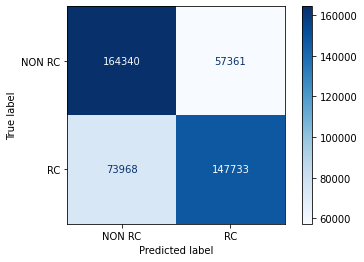

In [62]:
disp = plot_confusion_matrix(model, X_eval, y_eval,
                             display_labels=['NON RC', 'RC'],
                             cmap=plt.cm.Blues,)